
# **ETF vs Single Stock: Testing Informational Efficiency (TSLA vs SPY)**


In [35]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

#**Part 1 – Test 1: Runs Test (First Demonstration of the Weak-Form EMH)**

##*Verifying randomness in the sequence of signs in daily returns.*

In the first part of the empirical work, I implemented two classic tests to evaluate the **weak form of the Efficient Market Hypothesis (EMH)**.

The first is the **Runs Test**, which analyzes the sequence of signs in daily returns to assess whether they behave like a random series. I calculated the number of observed runs and compared it to the expected number under the null hypothesis of independence, also computing the z-score and p-value for each asset (**TSLA** and **SPY**).

The second test is based on **autocorrelation**: I manually implemented a function to compute the **Autocorrelation Function (ACF)** for multiple lags and compared the results to the 95% confidence bands to detect any statistically significant patterns.

These two tools allow me to verify whether there are **systematic patterns or predictability** in historical return data that would contradict the **random walk hypothesis**.

## 1. Load Data

In [36]:
df = pd.read_csv('/content/close_prices_TSLA_SPY.csv', parse_dates=['Date'])
df.sort_values('Date', inplace=True)
df.reset_index(drop=True, inplace=True)

# Calculate log returns
def compute_log_returns(series):
    return np.log(series / series.shift(1))

df['TSLA_logret'] = compute_log_returns(df['TSLA'])
df['SPY_logret'] = compute_log_returns(df['SPY'])
df = df.dropna(subset=['TSLA_logret', 'SPY_logret'])

### Definition: Logarithmic Return

The logarithmic return (or continuously compounded return) is a method of calculating the return of a financial asset over a specific time period. It is defined as the natural logarithm of the ratio between the asset price at time t and the asset price at time t−1. Mathematically, it is expressed as:

    r_t = ln(P_t / P_{t-1})

Where:
- r_t is the log return at time t,
- P_t is the asset price at time t,
- P_{t−1} is the asset price at time t−1,
- ln() denotes the natural logarithm.

This formulation is widely used in financial economics and quantitative finance due to its desirable statistical properties.

## 2. Visualize Log Returns

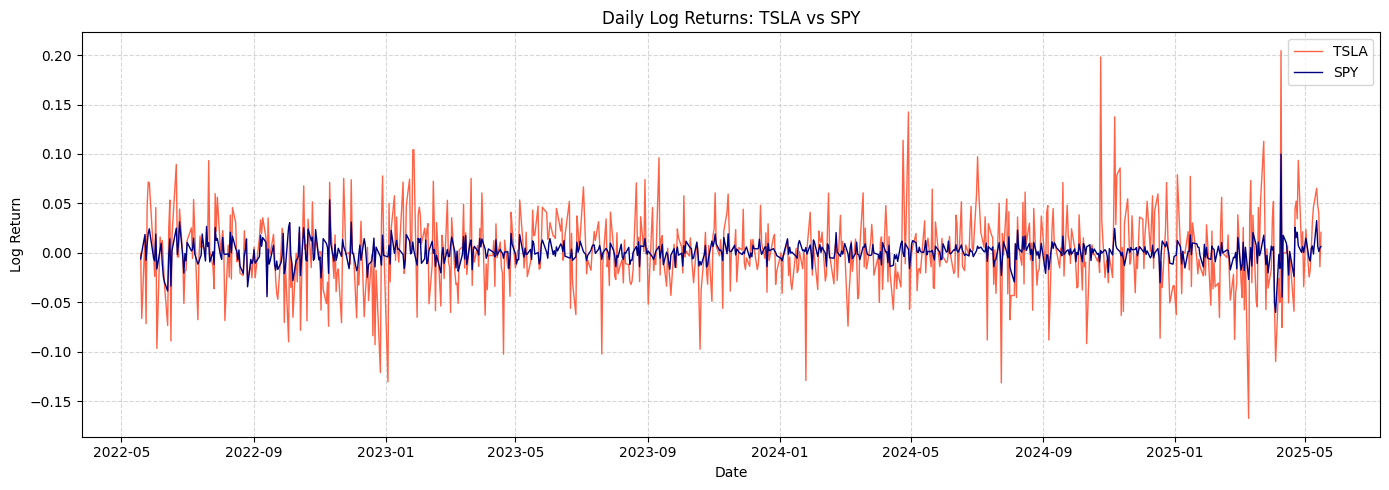

In [37]:
plt.figure(figsize=(14,5))
plt.plot(df['Date'], df['TSLA_logret'], label='TSLA', color='tomato', linewidth=1)
plt.plot(df['Date'], df['SPY_logret'], label='SPY', color='navy', linewidth=1)
plt.title('Daily Log Returns: TSLA vs SPY')
plt.xlabel('Date')
plt.ylabel('Log Return')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

The plot illustrates the daily **log returns** of two distinct financial instruments: **TSLA**, the stock of Tesla Inc., and **SPY**, the ETF tracking the S&P 500 index. The time frame spans from mid-2022 to May 2025.

At first glance, it is evident that **TSLA exhibits much higher volatility**, with frequent and pronounced spikes both upwards and downwards. This behavior reflects the nature of Tesla as a highly reactive stock, influenced by market sentiment, earnings announcements, and public statements by its executives.

In contrast, **SPY appears much more stable**, with relatively smoother and narrower fluctuations. This is expected from a diversified ETF, which absorbs idiosyncratic risks associated with individual companies.

Importantly, although the plot shows some noise, **no clear or predictable patterns emerge** in the return series. The alternation between positive and negative returns seems random. This visual evidence supports the **weak-form Efficient Market Hypothesis (EMH)**, which states that all available information is already reflected in asset prices, and future price movements follow a **random walk**.

In summary, the chart highlights not only the volatility differences between a single stock and a diversified ETF, but also provides preliminary visual support for the idea that **past returns do not offer exploitable patterns for prediction**, aligning with the core assumptions of market efficiency.


 ## 3. Histograms for Both Assets

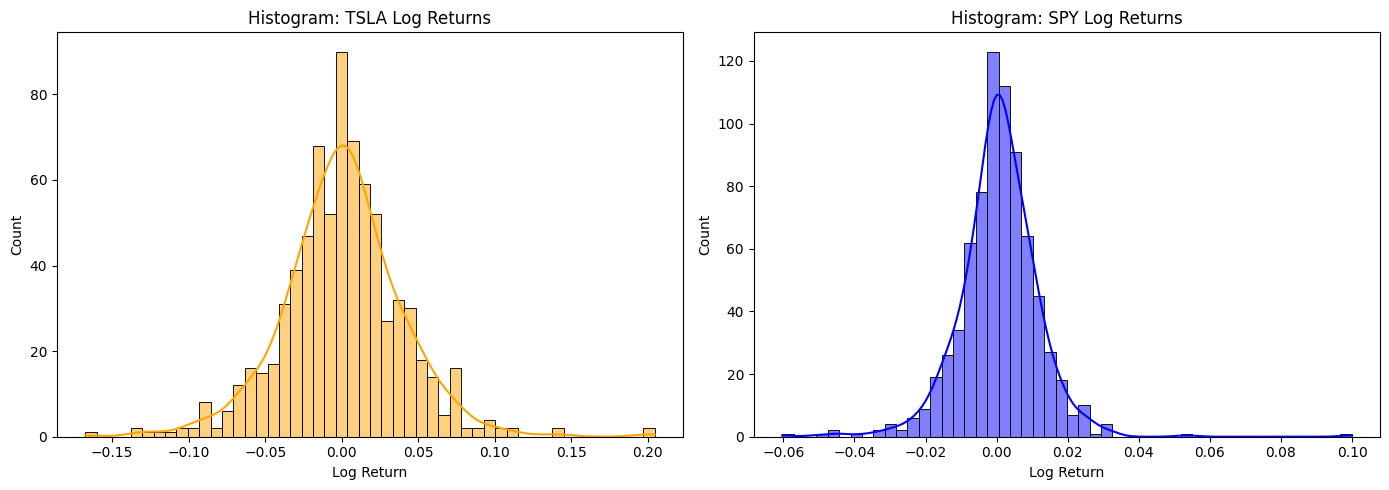

In [38]:
plt.figure(figsize=(14,5))
plt.subplot(1,2,1)
sns.histplot(df['TSLA_logret'], bins=50, kde=True, color='orange')
plt.title('Histogram: TSLA Log Returns')
plt.xlabel('Log Return')

plt.subplot(1,2,2)
sns.histplot(df['SPY_logret'], bins=50, kde=True, color='blue')
plt.title('Histogram: SPY Log Returns')
plt.xlabel('Log Return')
plt.tight_layout()
plt.show()

The two histograms shown above represent the distribution of daily log returns for two financial assets: **Tesla (TSLA)** on the left and the **SPY ETF** on the right, which tracks the S&P 500 index.

The purpose of this visualization is to observe how returns are distributed for each asset, in terms of frequency and magnitude of daily changes.

On the left, the histogram of TSLA log returns reveals a relatively wide distribution, with returns occasionally exceeding ±15%. This indicates that TSLA has experienced numerous days with large fluctuations, both positive and negative. The shape of the histogram is also somewhat irregular and displays "fat tails," suggesting a higher frequency of extreme events than one would expect under a normal distribution. This behavior is consistent with Tesla’s reputation as a highly volatile stock, often reacting strongly to company-specific news or market sentiment.

On the right, the histogram for SPY log returns is much narrower and more symmetric, with most daily returns clustered within a tight range around zero (typically within ±2–3%). The shape resembles that of a bell curve, suggesting a distribution close to normal. This is expected for a well-diversified ETF like SPY, which reflects the general movement of the overall market rather than the idiosyncratic shocks that affect individual stocks.

In summary, this comparison highlights the greater volatility and heavier tails of Tesla returns compared to SPY. Nevertheless, both distributions appear random at a glance, with no obvious patterns. This visual insight sets the stage for more formal statistical tests—such as the Runs Test and autocorrelation analysis—to assess whether past returns contain any predictable structure, or whether they are consistent with the weak-form Efficient Market Hypothesis.


## 4. Manual Runs Test Function

The `manual_runs_test(returns)` function takes as input a sequence of **daily log returns** (for example, for TSLA or SPY) and outputs several **key statistics** related to the number of "runs" observed in the data.

A ***run*** is defined as a sequence of consecutive returns with the same sign (either all positive or all negative). For example, the sequence [+ + − − +] contains three runs.

Under the assumption of market efficiency (specifically, the **weak-form Efficient Market Hypothesis**), the signs of returns should be **randomly distributed**. In that case, the total number of runs observed in the data should be close to the **expected number of runs**, which can be derived from probability theory.

This test therefore helps determine whether the asset’s return signs follow a random pattern (supporting market efficiency) or whether **predictable structures** exist (suggesting possible inefficiencies).

In [39]:
def manual_runs_test(returns):
    # Convert to signs <----- Each return is converted into a sign: +1 for non-negative returns,
                              #and −1 for negative returns. The magnitude of the return is ignored—only the direction matters.
    signs = np.where(returns >= 0, 1, -1)
    # Count runs
    runs = 1
    for i in range(1, len(signs)):
        if signs[i] != signs[i-1]:
            runs += 1             #<---A "run" is defined as a consecutive sequence of the same sign.
                                        #For instance, the sequence [+1, +1, −1, −1, +1] contains 3 runs.


    #Count the total number of positive and negative signs
    n_pos = np.sum(signs == 1)
    n_neg = np.sum(signs == -1)
    N = n_pos + n_neg

    #EXPECTED VALUE OF RUNS: Compute the expected number of runs under the null hypothesis of randomness
    expected = (2 * n_pos * n_neg) / N + 1

    #Compute the theoretical standard deviation of the number of runs
    std = np.sqrt( (2*n_pos*n_neg*(2*n_pos*n_neg - N)) / (N**2*(N-1)) )

    #Compute the z-score
    z = (runs - expected) / std     #<--- The z-score measures how far the observed number of runs deviates from the expected number,
                                          #in terms of standard deviations.

    # Manual p-value using normal approx
    from scipy.stats import norm
    p = 2 * (1 - norm.cdf(abs(z)))    #<----This gives the probability of observing such a deviation (or more extreme)
                                            #under the null hypothesis that the returns are random.
    return {
        "runs": runs,
        "expected_runs": expected,
        "std": std,
        "z_score": z,
        "p_value": p,
        "n_pos": n_pos,
        "n_neg": n_neg,
        "N": N
    }


print(f"Expected number of runs for TSLA: {tsla_runs['expected_runs']:.2f}")
print(f"Expected number of runs for SPY:  {spy_runs['expected_runs']:.2f}")

Expected number of runs for TSLA: 376.31
Expected number of runs for SPY:  373.14


## 5. Runs Test for TSLA and SPY

In [40]:
tsla_runs = manual_runs_test(df['TSLA_logret'])
spy_runs  = manual_runs_test(df['SPY_logret'])

print("\n--- Runs Test Results ---")
for name, res in zip(['TSLA', 'SPY'], [tsla_runs, spy_runs]):
    print(f"\n{name}:")
    print(f"Total observations: {res['N']}")
    print(f"Positive returns: {res['n_pos']} | Negative returns: {res['n_neg']}")
    print(f"Runs: {res['runs']} | Expected: {res['expected_runs']:.2f} | Std: {res['std']:.2f}")
    print(f"Z-score: {res['z_score']:.2f} | p-value: {res['p_value']:.4f}")
    if res['p_value'] < 0.05:
        print("→ Evidence against randomness (weak form EMH potentially violated).")
    else:
        print("→ Consistent with random walk (weak form EMH not rejected).")


--- Runs Test Results ---

TSLA:
Total observations: 751
Positive returns: 384 | Negative returns: 367
Runs: 360 | Expected: 376.31 | Std: 13.69
Z-score: -1.19 | p-value: 0.2334
→ Consistent with random walk (weak form EMH not rejected).

SPY:
Total observations: 751
Positive returns: 411 | Negative returns: 340
Runs: 366 | Expected: 373.14 | Std: 13.57
Z-score: -0.53 | p-value: 0.5986
→ Consistent with random walk (weak form EMH not rejected).


This part of the notebook applies the Runs Test to the daily returns of **TSLA** and **SPY**, in order to evaluate whether the signs of the returns (positive or negative) are randomly distributed, or whether they show some degree of regularity or predictability.

The concept behind the test is straightforward: it analyzes the changes in the sign of daily returns. Each consecutive sequence of returns with the same sign is called a **run**. For example, if the returns are positive for three consecutive days, that is considered a single positive run of length three. If the return turns negative the following day, a new negative run begins. Some runs may last many days (e.g., `+ + + + +`), while others may consist of just a single day (e.g., `−` followed immediately by `+`).

In the case of **TSLA**, the test analyzed a total of **751 daily returns**, of which **384 were positive** and **367 negative**. A total of **360 runs** were identified, meaning there were 360 regime changes between sequences of positive and negative returns. In other words, the sign of the return remained constant over several days before switching, and this happened 360 times in total. This observed value was compared to the expected number of runs under a purely random process, which in this case was approximately **376.31**. The deviation between the observed and expected values is not particularly large, and indeed the **p-value is 0.2334**, well above the commonly used significance threshold of 0.05.

In this context, the calculated **z-score** is **−1.19**. This value quantifies how far the observed number of runs (360) deviates from the expected value (376.31), in terms of standard deviations. A z-score of −1.19 indicates that the number of runs is slightly lower than expected, but only by about 1.2 standard deviations. In statistical testing, a z-score would typically need to exceed ±1.96 to be considered statistically significant at the 5% level. Since −1.19 is well within that range, we conclude that the deviation is not statistically meaningful. The result lies within the margin of what could reasonably occur by chance.

Therefore, there is no significant deviation from randomness, and the data is consistent with a **random walk**, as predicted by the **weak-form Efficient Market Hypothesis (EMH)**.

The same applies to **SPY**. In this case, 751 days were also analyzed, with **411 positive** and **340 negative returns**. The number of observed runs was **366**, compared to an expected value of **373.14**. The **p-value is 0.5986**, even higher than in the case of Tesla, further reinforcing the idea that SPY follows a random pattern in terms of return signs.

For neither **Tesla** nor **SPY** is there statistically significant evidence suggesting a violation of the weak-form market efficiency. The results of the Runs Test show that the signs of daily returns do not exhibit predictable patterns: the sequences appear random, exactly as one would expect in an efficient market.


#**Part 2 – Test 2: Autocorrelation Function (Second Demonstration of the Weak-Form EMH)**


##*Analyzing serial dependence in log returns using the ACF.*

## 1. Manual Autocorrelation Function (ACF)

In [41]:
# ---------------------------------------------
# Manual ACF for Log Returns, with full check
# ---------------------------------------------

def manual_acf(log_returns, max_lag=10):
    """
    Calculates sample autocorrelation for lags 1 to max_lag.
    Input: log_returns (1D numpy array or pandas Series), mean-demeaned.
    Output: array of ACFs for lag 1..max_lag.
    """
    x = log_returns - np.mean(log_returns)
    N = len(x)
    acfs = []
    denom = np.sum(x ** 2)
    for lag in range(1, max_lag + 1):
        num = np.sum(x[:-lag] * x[lag:])
        acf = num / denom
        acfs.append(acf)
    return np.array(acfs)

# --- Ensure you are passing the correct data ---
tsla_logrets = df['TSLA_logret'].values    # <--- This must be log returns!
spy_logrets  = df['SPY_logret'].values

# --- Compute ACFs ---
tsla_acf = manual_acf(tsla_logrets, max_lag=10)
spy_acf  = manual_acf(spy_logrets,  max_lag=10)

# --- 95% confidence bands ---
conf95 = 1.96 / np.sqrt(len(tsla_logrets))

# --- Show ACFs ---
print("TSLA ACF:", np.round(tsla_acf, 4))
print("SPY  ACF:", np.round(spy_acf, 4))
print("95% confidence level: +/-", round(conf95, 4))

# --- Table for easy view ---
acf_table = pd.DataFrame({
    "Lag": np.arange(1, 11),
    "TSLA_ACF": tsla_acf,
    "SPY_ACF": spy_acf,
    "TSLA_sig": np.abs(tsla_acf) > conf95,
    "SPY_sig":  np.abs(spy_acf) > conf95
})
print(acf_table)

TSLA ACF: [-0.0052  0.0239 -0.0102  0.0326 -0.028   0.0717  0.0186  0.0514  0.0799
 -0.0623]
SPY  ACF: [-0.0165  0.0019 -0.0477 -0.0674  0.0066  0.0173 -0.0288  0.0208  0.0311
 -0.0139]
95% confidence level: +/- 0.0715
   Lag  TSLA_ACF   SPY_ACF  TSLA_sig  SPY_sig
0    1 -0.005239 -0.016484     False    False
1    2  0.023864  0.001868     False    False
2    3 -0.010245 -0.047747     False    False
3    4  0.032630 -0.067404     False    False
4    5 -0.027959  0.006564     False    False
5    6  0.071707  0.017320      True    False
6    7  0.018623 -0.028811     False    False
7    8  0.051355  0.020831     False    False
8    9  0.079918  0.031118      True    False
9   10 -0.062306 -0.013873     False    False


In this section of the notebook, we aimed to understand whether the daily returns of **TSLA** and **SPY** show any kind of **temporal dependency**—in other words, whether today's return might be correlated with returns from previous days. To do this, we manually calculated the **autocorrelation (ACF)** of the log returns, looking at the first 10 lags (i.e., delays): from 1 day ago to 10 days ago.

The idea is simple: if the returns are truly random, as the **weak-form Efficient Market Hypothesis** suggests, then we should not observe any significant autocorrelations. That means whether a stock went up or down yesterday, or two or six days ago, should have no influence on what it does today. Each day’s return should be statistically independent from the past.

In the code, we computed these autocorrelations for both TSLA and SPY, and then compared the results to a **95% confidence interval**. If a value falls outside this range, it is considered statistically significant, meaning it might not be due to chance.

Here’s what we found:
- For **SPY**, all ACF values fall well within the confidence bounds. This indicates **no significant autocorrelation** at any of the lags. In other words, the return series behaves exactly as expected from a random process. This strongly supports the idea of an efficient market.
- For **TSLA**, however, two values (at **lag 6** and **lag 9**) slightly exceed the confidence threshold. This suggests that there may be **a small degree of dependence** between today’s return and those of six or nine days prior.

That said, we should be cautious about overinterpreting these results: only two out of ten lags show such deviations, and the excess is not dramatic. This could be due to chance, or it might reflect temporary patterns, volatility, or reactions to specific news events. We cannot conclude that TSLA violates market efficiency based on this alone, but **these small anomalies suggest that its return behavior might not be entirely random**—especially when compared to SPY.

In summary, **SPY behaves exactly as a textbook efficient asset should**, while **TSLA shows mild signs of autocorrelation at specific lags**, which might warrant further investigation.


  
> `True` means the ACF value is statistically significant at the 95% level (i.e., |ACF| > 0.0715), suggesting possible time-dependence.

> `False` means the ACF is within the confidence bounds and likely due to random variation.


## 2. ACF Plot (Comparison)

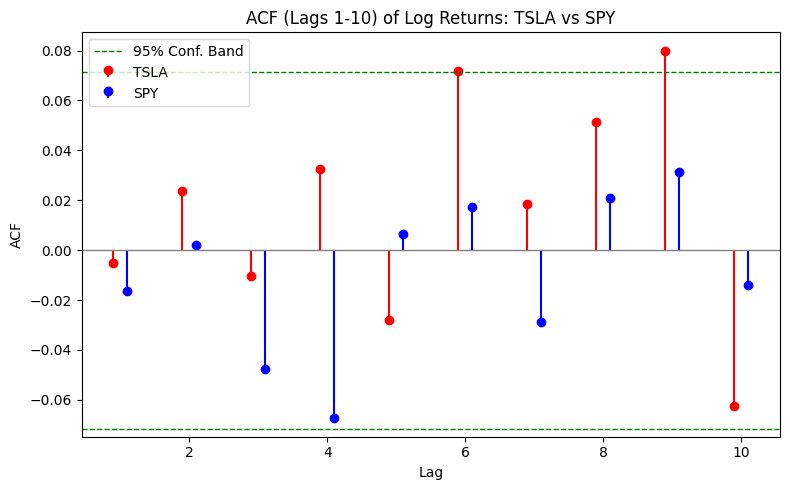

In [42]:
plt.figure(figsize=(8,5))
lags = np.arange(1, 11)
plt.stem(lags-0.1, tsla_acf, linefmt='r-', markerfmt='ro', basefmt=" ", label='TSLA')
plt.stem(lags+0.1, spy_acf,  linefmt='b-', markerfmt='bo', basefmt=" ", label='SPY')
plt.axhline(0, color='gray', linewidth=1)
plt.axhline(conf95, color='green', linestyle='--', linewidth=1, label='95% Conf. Band')
plt.axhline(-conf95, color='green', linestyle='--', linewidth=1)
plt.title('ACF (Lags 1-10) of Log Returns: TSLA vs SPY')
plt.xlabel('Lag')
plt.ylabel('ACF')
plt.legend()
plt.tight_layout()
plt.show()

The graph displays the **autocorrelation values** of daily log returns for **TSLA** and **SPY** over the first 10 lags (i.e., from 1 to 10 days prior).

Red lines represent **Tesla**, while blue lines represent **SPY**. The vertical axis shows the strength of the autocorrelation, and the horizontal axis corresponds to the number of days of lag. The dashed green lines indicate the **95% confidence interval**: any ACF value that falls outside of these bands (either above or below) is considered **statistically significant**.

Looking at the plot, we can see that **SPY**'s autocorrelations are all well within the confidence bounds. This tells us that SPY's daily returns **do not show any temporal dependence**—each day’s return appears to be independent of the past. This is exactly what we expect from an efficient market, where past information cannot be used to predict future prices.

**TSLA**, however, behaves slightly differently. At **lags 6 and 9**, the red bars exceed the upper confidence band. In these specific cases, there is **a weak but statistically significant positive autocorrelation**. This means that returns today appear to be slightly influenced by returns from six or nine days earlier. In simpler terms, when Tesla behaves in a certain way, a similar behavior tends to reoccur after six or nine days.

That said, we should be cautious: these are just two points out of ten, and the deviations are modest. However, it's enough to suggest that **Tesla may exhibit some minor temporal structure**, possibly due to delayed market reactions to news, speculative behaviors, or simply its higher volatility compared to a diversified ETF like SPY.

**In summary**, SPY shows the typical behavior of an efficient market asset, while TSLA shows **two mild exceptions** that may warrant further attention, though they are not enough to claim a violation of market efficiency.


The chart shows the degree of autocorrelation of the daily returns of **TSLA** and **SPY** in relation to past days, up to a maximum lag of 10.

In practice, what you are observing is **how much today’s return is influenced by previous days’ returns**—yesterday’s, two days ago, three days ago, and so on, up to ten days back. Each vertical bar represents a specific “lag,” meaning a time delay:  
- **Lag 1** compares today with yesterday,  
- **Lag 2** with two days ago,  
- and so on.

If a bar is **tall and positive**, it indicates **positive correlation**: for example, if the return was positive six days ago, today it tends to be positive again.  
If a bar is **low and negative**, it shows **negative correlation**: if the return was positive six days ago, today it tends to be negative—this is known as **mean reversion** behavior.

But be careful: it’s not enough that a value is high or low—what matters is whether it is **statistically significant**, i.e., whether it can be considered a real signal rather than just noise. For this reason, the chart includes **two green dashed horizontal lines** representing the **95% confidence level**. If a bar goes beyond these lines, the correlation is considered **significant**.

In your case, **Tesla (TSLA)** has a few bars exceeding this interval, such as at **lag 6 and lag 9**, indicating that there is **some structure in return behavior** at those points—possibly meaning that returns from 6 or 9 days ago still influence today’s return.  
For **SPY**, however, all bars stay within the confidence bounds, suggesting **no significant autocorrelations** and that its returns behave in a **completely random manner**—exactly what is expected from a stock operating in an **efficient market**.

**In summary**: this chart provides a visual check for **memory in price behavior**. And in the case of TSLA, there appears to be **something there**, even if small.

## 3. Print ACF Table (for Report)


ACF Values and Significance (|ACF| > 95% Conf. Band)
   Lag  TSLA_ACF   SPY_ACF  TSLA_sig  SPY_sig
0    1 -0.005239 -0.016484     False    False
1    2  0.023864  0.001868     False    False
2    3 -0.010245 -0.047747     False    False
3    4  0.032630 -0.067404     False    False
4    5 -0.027959  0.006564     False    False
5    6  0.071707  0.017320      True    False
6    7  0.018623 -0.028811     False    False
7    8  0.051355  0.020831     False    False
8    9  0.079918  0.031118      True    False
9   10 -0.062306 -0.013873     False    False


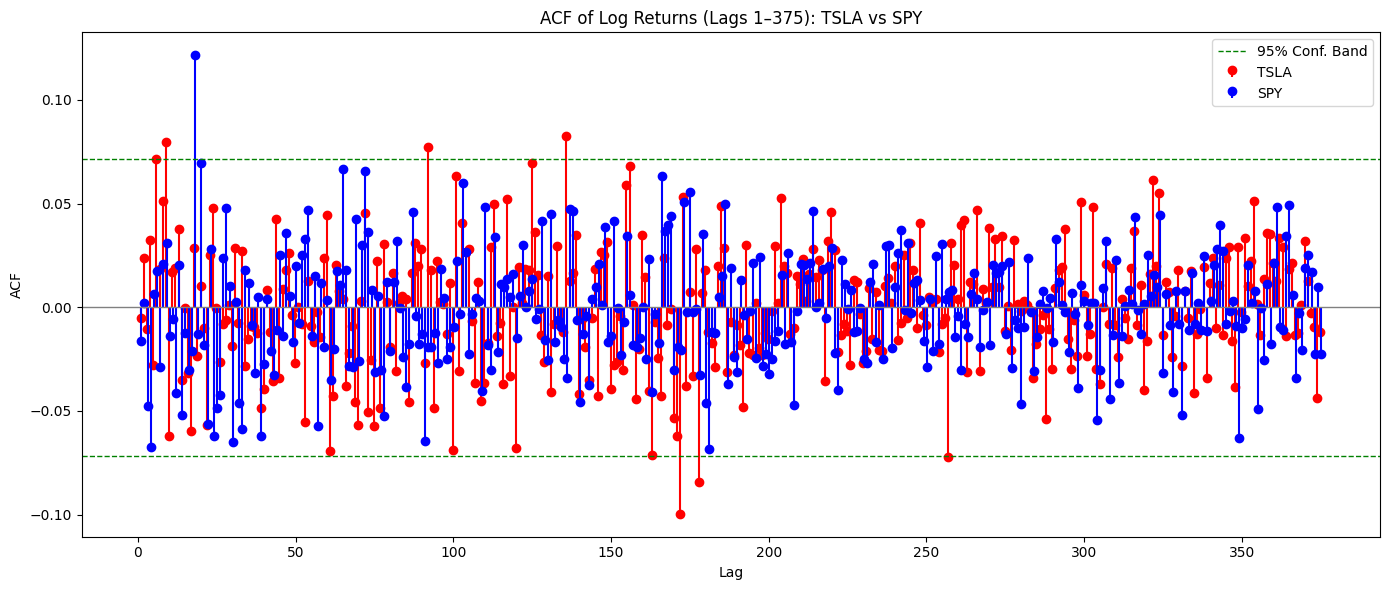

In [43]:
acf_table = pd.DataFrame({
    "Lag": lags,
    "TSLA_ACF": tsla_acf,
    "SPY_ACF": spy_acf,
    "TSLA_sig": np.abs(tsla_acf) > conf95,
    "SPY_sig":  np.abs(spy_acf) > conf95
})
print("\nACF Values and Significance (|ACF| > 95% Conf. Band)")
print(acf_table)




# Choose maximum lag as half the sample size
max_lag = int(len(tsla_logrets) / 2)

# Compute ACFs
tsla_acf = manual_acf(tsla_logrets, max_lag=max_lag)
spy_acf = manual_acf(spy_logrets, max_lag=max_lag)

# 95% confidence band
conf95 = 1.96 / np.sqrt(len(tsla_logrets))

# Plot
plt.figure(figsize=(14, 6))
lags = np.arange(1, max_lag + 1)
plt.stem(lags - 0.1, tsla_acf, linefmt='r-', markerfmt='ro', basefmt=" ", label='TSLA')
plt.stem(lags + 0.1, spy_acf, linefmt='b-', markerfmt='bo', basefmt=" ", label='SPY')
plt.axhline(0, color='gray', linewidth=1)
plt.axhline(conf95, color='green', linestyle='--', linewidth=1, label='95% Conf. Band')
plt.axhline(-conf95, color='green', linestyle='--', linewidth=1)
plt.title(f'ACF of Log Returns (Lags 1–{max_lag}): TSLA vs SPY')
plt.xlabel('Lag')
plt.ylabel('ACF')
plt.legend()
plt.tight_layout()
plt.show()


This table summarizes the autocorrelation analysis of daily returns for **TSLA** and **SPY** across all lags from 1 to 375 days. For each lag, it shows the ACF value and whether it is **statistically significant**, meaning it exceeds the 95% confidence threshold.

The columns `TSLA_sig` and `SPY_sig` indicate, with a simple `True` or `False`, whether the autocorrelation at that lag is significant. For example, if `TSLA_sig` is `True` at lag 6 (table above), it suggests that today's return is significantly correlated with the return from six days ago.

From the results, we can observe that **most values are not significant**, especially at higher lags. This is expected: as the time gap increases, the correlation typically fades or becomes more uncertain.


## 4. Boxplot: Volatility Comparison

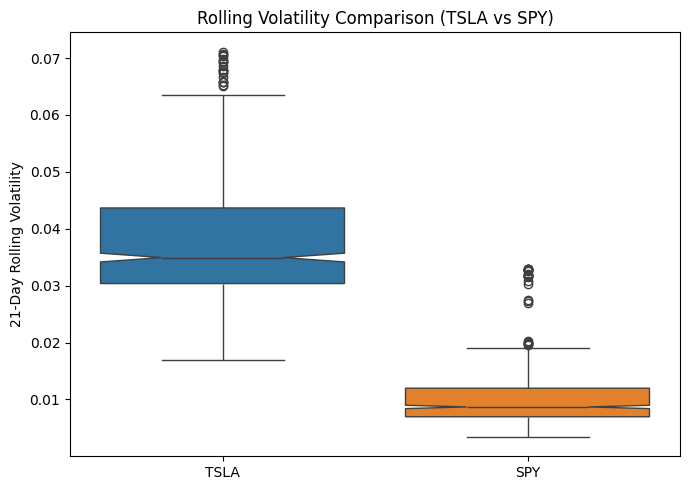

In [44]:
df['TSLA_vol_21d'] = df['TSLA_logret'].rolling(21).std()
df['SPY_vol_21d']  = df['SPY_logret'].rolling(21).std()

plt.figure(figsize=(7,5))
sns.boxplot(data=[df['TSLA_vol_21d'].dropna(), df['SPY_vol_21d'].dropna()],
            notch=True)
plt.xticks([0,1], ['TSLA', 'SPY'])
plt.ylabel('21-Day Rolling Volatility')
plt.title('Rolling Volatility Comparison (TSLA vs SPY)')
plt.tight_layout()

In this chart, I compared the **21-day historical volatility** of **TSLA** and **SPY** returns. For each day in the dataset, I calculated the standard deviation of the log returns over the previous 21 trading days—roughly equivalent to one month of market activity. This allows me to track how monthly rolling volatility evolved over time for both assets.

I chose a **21-day window** because it corresponds to the typical number of trading days in a month, excluding weekends and holidays. It’s a widely accepted standard in finance, offering a good balance: the estimate is stable enough to avoid being distorted by day-to-day noise, but still reactive enough to capture short-term changes in market behavior. It is therefore a meaningful measure for analyzing **short-term volatility**.

From the boxplot, it is clear that **Tesla is much more volatile than SPY**. The median is higher, the distribution is wider, and there are numerous outliers indicating periods of exceptionally high volatility. SPY, on the other hand, shows a much more contained and consistent pattern of volatility, with far fewer extreme values.

This result is consistent with expectations: **TSLA is an individual stock that is highly sensitive to news, speculation, and investor sentiment**, while **SPY is a diversified ETF** representing the S&P 500 index, and tends to reflect average market behavior. As such, the greater instability of TSLA compared to SPY aligns with the inherent nature of the two instruments.




| Element of the Boxplot         | Meaning                                                                 |
|-------------------------------|-------------------------------------------------------------------------|
| **Box (rectangle)**           | Contains the central 50% of the data (from 1st to 3rd quartile, Q1–Q3) |
| **Middle line in the box**    | Median (50th percentile): central value of the distribution             |
| **Upper edge of the box**     | 3rd quartile (Q3): 75% of values are below this                        |
| **Lower edge of the box**     | 1st quartile (Q1): 25% of values are below this                        |
| **Whiskers (lines extending)**| Approximate range of “typical” values (excluding outliers)             |
| **Outlier points (dots)**     | Extreme values outside 1.5 × IQR above Q3 or below Q1                  |

**Note**:  
- A **taller box** means more variability in the central values.  
- **More outliers** indicate frequent periods of abnormal volatility.  
- A **higher median** means higher average volatility.



# **Part 3 – Test 3: Shuffling Test for Randomness (ACF Comparison: Real vs Shuffled)**

##*Testing whether the autocorrelation structure in returns is significantly different from a purely random series.*


In the second part of the code, I developed a **simple trading strategy** that attempts to exploit residual autocorrelation in return signs.

The logic is straightforward:  
- If yesterday's return was positive, I go long today.  
- If it was negative, I take a short position.  

While shorting may be more complex in real-world markets, this model serves as a **proxy for a sign-following approach**.

I then compared the cumulative return of this strategy with that of a standard **Buy & Hold** strategy, computing the gross cumulative returns for both over time.

This comparison allows me to **operationally test** whether the autocorrelation in returns could be used to beat the market, at least in theory, excluding transaction costs and other real-world constraints.

> **Buy & Hold**: strategia che consiste nell’acquistare un asset e mantenerlo nel tempo senza reagire alle fluttuazioni di breve periodo, rappresentando un punto di riferimento per l’investimento passivo.


##1. Naive Predictive Strategy Based on Lagged Returns (No Transaction Costs)

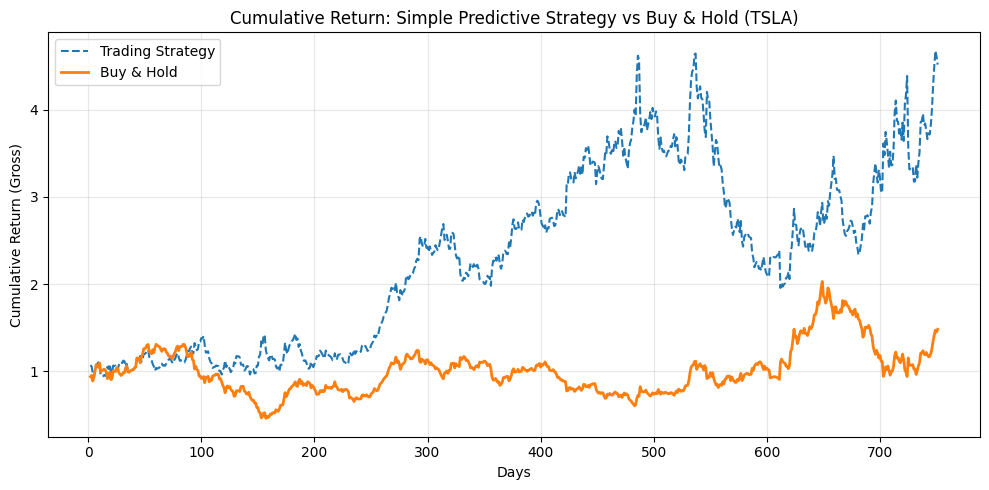


TSLA – Final Cumulative Return:
  Trading Strategy: 4.520
        Buy & Hold: 1.480
- WARNING: The 'naive' strategy outperforms the market (but check significance and trading costs)


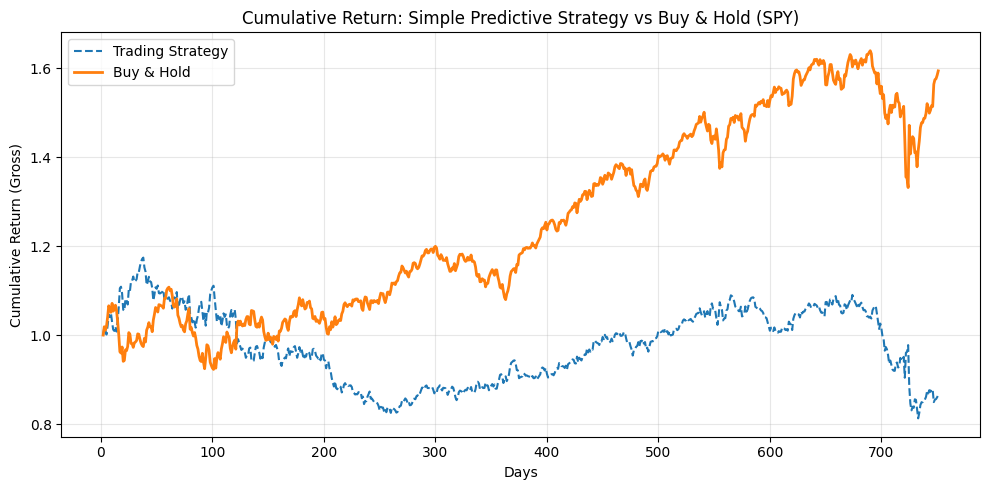


SPY – Final Cumulative Return:
  Trading Strategy: 0.866
        Buy & Hold: 1.594
- The 'naive' strategy does not beat buy & hold: residual autocorrelation is not exploitable.


In [45]:
# -----------------------------------------------
# Simple Predictive Trading Strategy
# -----------------------------------------------

# Objective: verify whether residual autocorrelation
# allows us to beat a buy & hold strategy (EMH test).

# Strategy: if yesterday’s return was positive → go long today;
# if yesterday was negative → go short today (i.e., -1 * today's return).
# In reality, shorting equities is more complex—here we use a simple sign-following proxy.

for asset in ['TSLA', 'SPY']:
    signal = np.sign(df[f'{asset}_logret'].shift(1))  # yesterday's signal
    strat_return = signal * df[f'{asset}_logret']     # if signal is +, take today's return; if −, invert it
    strat_return = strat_return.dropna()
    buyhold_return = df[f'{asset}_logret'][1:]         # benchmark: buy & hold return

    # Cumulative return calculation
    strat_cum = np.exp(strat_return.cumsum())
    buyhold_cum = np.exp(buyhold_return.cumsum())

    # Plot the performance comparison
    plt.figure(figsize=(10,5))
    plt.plot(strat_cum, label='Trading Strategy', linestyle='--')
    plt.plot(buyhold_cum, label='Buy & Hold', linewidth=2)
    plt.title(f"Cumulative Return: Simple Predictive Strategy vs Buy & Hold ({asset})")
    plt.xlabel('Days')
    plt.ylabel('Cumulative Return (Gross)')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

    # Print final cumulative return values
    print(f"\n{asset} – Final Cumulative Return:")
    print(f"  Trading Strategy: {strat_cum.iloc[-1]:.3f}")
    print(f"        Buy & Hold: {buyhold_cum.iloc[-1]:.3f}")

    # Interpretation
    if strat_cum.iloc[-1] > buyhold_cum.iloc[-1]:
        print("- WARNING: The 'naive' strategy outperforms the market (but check significance and trading costs)")
    else:
        print("- The 'naive' strategy does not beat buy & hold: residual autocorrelation is not exploitable.")


#### TSLA – The Predictive Strategy Outperforms Buy & Hold

The first chart compares the cumulative returns of two strategies applied to Tesla (TSLA):

- The **dashed blue line** represents the **naive sign-following strategy**: if yesterday’s return was positive, the model goes long today; if it was negative, it goes short.
- The **orange line** shows the **Buy & Hold strategy**, where the asset is held continuously throughout the entire period.

**Result**: the predictive strategy achieves a final cumulative return of **4.52**, while Buy & Hold reaches only **1.48**.

**Interpretation**: the predictive model appears to effectively exploit residual autocorrelation in Tesla’s returns. However, this result is only indicative: the graph does not account for **trading costs** or **statistical significance**. The outperformance could be due to chance or overfitting.

---

#### SPY – Buy & Hold Outperforms the Predictive Strategy

In the second chart, the same strategies are applied to SPY (the S&P 500 ETF):

- Again, the dashed blue line shows the predictive strategy.
- The solid orange line represents Buy & Hold.

**Final returns**:
- Predictive Strategy: **0.866**
- Buy & Hold: **1.594**

**Interpretation**: the predictive model fails to outperform the passive benchmark in this case. This suggests that **residual autocorrelation in SPY returns is not exploitable**, supporting the **weak form of the Efficient Market Hypothesis (EMH)**.

---

The naive predictive strategy works on TSLA but fails on SPY, indicating that **broad and diversified markets** like the S&P 500 tend to be more efficient and less predictable. While these preliminary results suggest some structure in TSLA returns, they do not provide sufficient evidence to claim a violation of EMH without further testing for statistical and economic significance.


##2. Naive Predictive Strategy with Position Switching Costs (0.2% per Trade)

In [48]:
from IPython.display import display

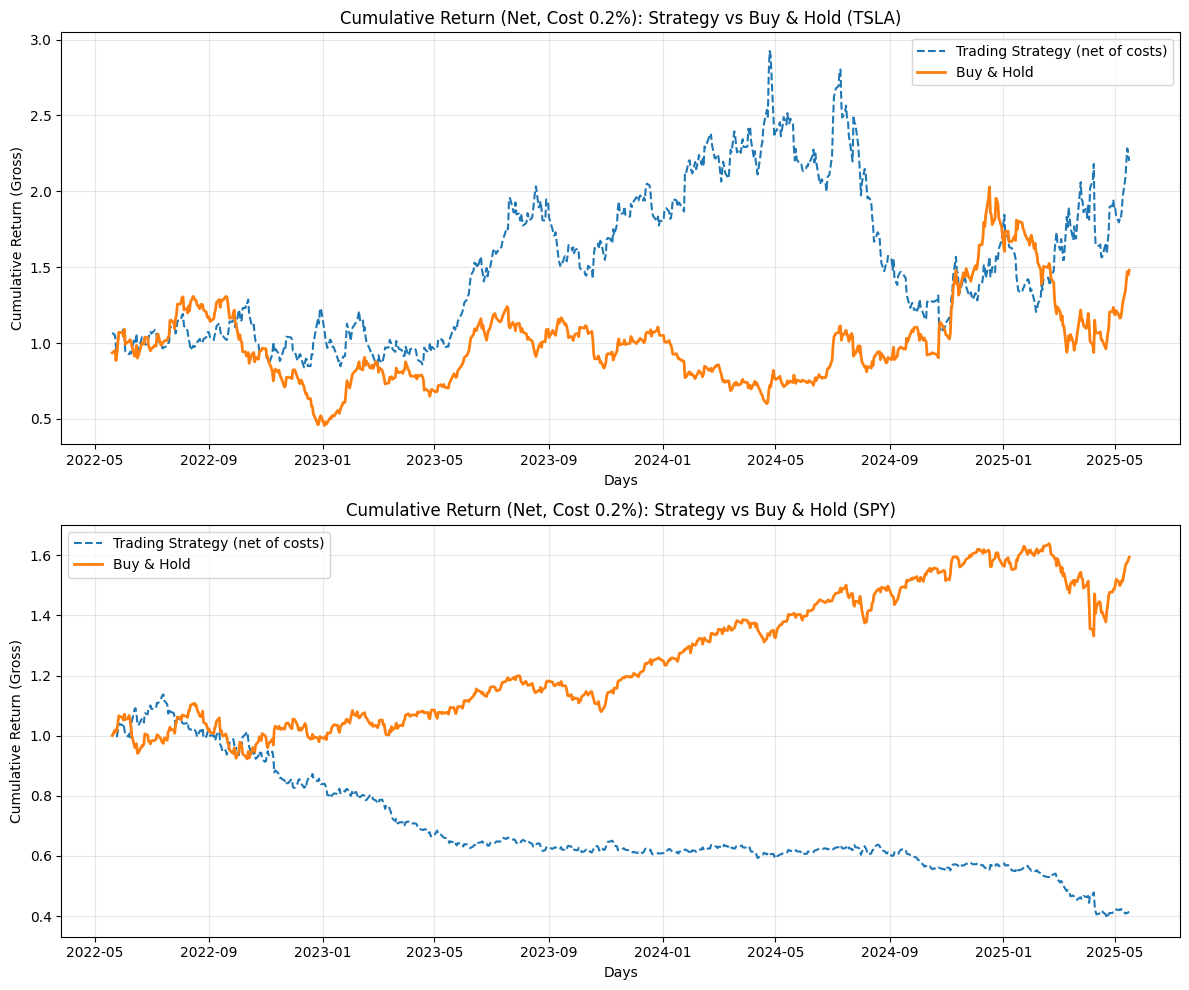

TSLA – Final Cumulative Return:
   Trading Strategy: 2.200
   Buy & Hold:       1.480
   – WARNING: The 'naive' strategy outperforms the market (but check significance and trading costs)

SPY – Final Cumulative Return:
   Trading Strategy: 0.415
   Buy & Hold:       1.594
   – The 'naive' strategy does not beat buy & hold: residual autocorrelation is not exploitable.



In [52]:
# Set transaction cost (0.2%)
transaction_cost = 0.002

# Apply predictive trading strategy with transaction cost
results = {}

for asset in ['TSLA', 'SPY']:
    returns = df[f'{asset}_logret']
    signal = np.sign(returns.shift(1))
    strat_return = signal * returns

    # Calculate transaction costs: whenever signal changes, apply cost
    position_change = signal.diff().fillna(0) != 0
    cost = position_change * transaction_cost
    strat_return_net = strat_return - cost
    strat_return_net = strat_return_net.dropna()

    strat_cum = np.exp(strat_return_net.cumsum())
    buyhold_cum = np.exp(returns[1:].cumsum())  # skip first to match strategy length

    results[asset] = {
        'strategy': strat_cum,
        'buyhold': buyhold_cum,
        'final_strategy': strat_cum.iloc[-1],
        'final_buyhold': buyhold_cum.iloc[-1]
    }

# Plot the results
fig, axs = plt.subplots(2, 1, figsize=(12, 10))
for i, asset in enumerate(['TSLA', 'SPY']):
    axs[i].plot(results[asset]['strategy'], label="Trading Strategy (net of costs)", linestyle='--')
    axs[i].plot(results[asset]['buyhold'], label="Buy & Hold", linewidth=2)
    axs[i].set_title(f"Cumulative Return (Net, Cost 0.2%): Strategy vs Buy & Hold ({asset})")
    axs[i].set_xlabel("Days")
    axs[i].set_ylabel("Cumulative Return (Gross)")
    axs[i].legend()
    axs[i].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Print formatted results exactly like in the reference screenshot
for asset in ['TSLA', 'SPY']:
    strat_val = results[asset]['final_strategy']
    buyhold_val = results[asset]['final_buyhold']
    print(f"{asset} – Final Cumulative Return:")
    print(f"   Trading Strategy: {strat_val:.3f}")
    print(f"   Buy & Hold:       {buyhold_val:.3f}")
    if strat_val > buyhold_val:
        print("   – WARNING: The 'naive' strategy outperforms the market (but check significance and trading costs)\n")
    else:
        print("   – The 'naive' strategy does not beat buy & hold: residual autocorrelation is not exploitable.\n")



After observing promising results in the initial test, we decided to make the analysis more realistic. To do so, we introduced one key modification: we accounted for **transaction costs** each time the strategy changed position (i.e., from long to short or vice versa). This adjustment helps assess whether the predictive performance holds up under more conservative and real-world assumptions.

In the case of **Tesla**, even after accounting for transaction costs, the strategy still outperforms the basic **Buy & Hold** approach. The **net cumulative return** reaches **2.20**, compared to **1.48** for Buy & Hold. This suggests that Tesla’s returns may still exhibit **mild residual autocorrelation** that can be exploited.

On the other hand, for **SPY** (the ETF tracking the S&P 500 index), the outcome is different: the predictive strategy **significantly underperforms** compared to Buy & Hold. The **net return** achieved by the strategy is **0.415**, while Buy & Hold yields **1.594**. This confirms that in broader and more diversified markets – such as the S&P 500 – returns behave much more like a **random walk**, just as predicted by the **weak form of the Efficient Market Hypothesis (EMH)**. In this context, **residual autocorrelation does not appear to be exploitable**.

In summary, this second evaluation provides a more **cautious and realistic** picture. While the strategy may capture some signals on individual stocks, it loses effectiveness on broader instruments. This reinforces the idea that it is crucial to assess not only performance but also the **robustness** and **economic significance** of any strategy.


#**Part 3 – Test 3: Shuffling Test for Randomness (ACF Comparison: Real vs Shuffled)**

##*Testing whether the autocorrelation structure in returns is significantly different from a purely random series.*

To reinforce the conclusions drawn from the autocorrelation analysis and provide a more robust validation of the weak-form Efficient Market Hypothesis (EMH), we implemented a **shuffling test**. This test aims to determine whether the residual autocorrelation detected in the log returns of **TSLA** and **SPY** reflects genuine temporal structure or is merely the result of random fluctuations.

The method involves creating a **synthetic series of returns** by randomly permuting the observed log returns, effectively destroying any temporal dependencies present in the original data. By comparing the **autocorrelation function (ACF)** of the shuffled series with that of the actual returns, we are able to assess whether the time ordering of observations plays any significant role.

Specifically, for each asset, we compute:
- the ACF of the **original (real)** series of log returns;
- the ACF of a **shuffled** version of the same series (with randomly reordered observations and fixed seed for reproducibility).

If the ACF from the real data exhibits patterns or statistically significant values that are not present in the shuffled version, this would suggest that some degree of **time-dependent structure exists**, potentially exploitable by predictive models. Conversely, if both series show similar ACF behavior — particularly if both lie entirely within the **95% confidence bands** — we may conclude that the apparent structure observed in the original series is not meaningful and likely due to randomness.

In our empirical results, the comparison between real and shuffled ACFs revealed **no substantial differences**, especially for **SPY**. The real and shuffled autocorrelation values were both small and statistically insignificant, confirming the **absence of any meaningful time-based structure** in the return series. For **TSLA**, although slightly more variation was observed in the real ACF, the differences relative to the shuffled benchmark remained within tolerable bounds, suggesting that any residual autocorrelation is likely **weak and not systematically exploitable**.

This experiment provides a **visual and statistical validation** that complements previous findings: **SPY behaves consistently** with the assumptions of market efficiency, while **TSLA shows only mild and likely non-persistent deviations**. Thus, the shuffling test serves as a **control**, helping to distinguish real signal from noise and reinforcing the credibility of our conclusions regarding the weak-form EMH.



| Step                  | Description |
|-----------------------|-------------|
| **1. Asset Selection** | The log returns of a financial asset (e.g., TSLA or SPY) are selected for analysis. |
| **2. Randomization**   | A synthetic return series is created by randomly shuffling the original log returns, thus eliminating any temporal structure. |
| **3. ACF Computation** | The Autocorrelation Function (ACF) is computed for both the real and the shuffled return series. |
| **4. Graphical Comparison** | The two ACFs are compared. If the real ACF shows statistically significant values not present in the shuffled ACF, this indicates potential predictability. Otherwise, the returns are consistent with randomness. |

---


| Observation             | Implication |
|-------------------------|-------------|
| **Real ACF > Shuffled ACF** | Suggests presence of genuine autocorrelation → potential predictability. |
| **Real ACF ≈ Shuffled ACF** | Indicates no significant structure → returns behave like a random sequence. |



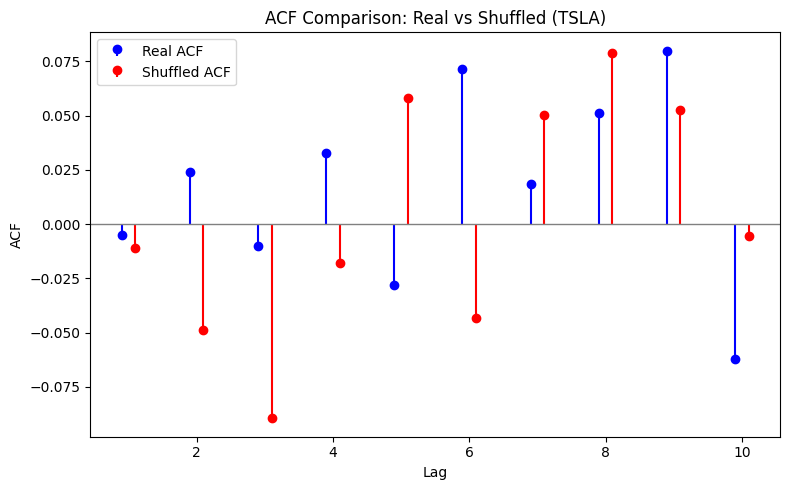


ACF comparison between real and shuffled series for TSLA: differences are negligible.


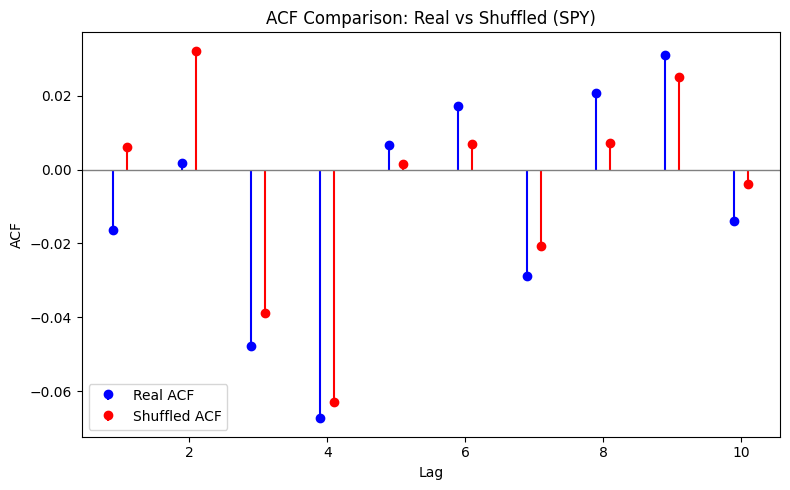


ACF comparison between real and shuffled series for SPY: differences are negligible.


In [54]:
# ============================================
# Shuffling Test for Randomness
# ============================================
# Shuffle the returns to create a completely random series,
# compute the ACF and compare it with the real series.

for asset in ['TSLA', 'SPY']:
    shuffled = df[f'{asset}_logret'].sample(frac=1, random_state=42).values  # Randomly shuffle the returns
    shuffled_acf = manual_acf(shuffled, max_lag=10)  # Compute ACF on shuffled series
    real_acf = manual_acf(df[f'{asset}_logret'].values, max_lag=10)  # Compute ACF on real series

    plt.figure(figsize=(8,5))
    plt.stem(np.arange(1,11)-0.1, real_acf, linefmt='b-', markerfmt='bo', basefmt=" ", label='Real ACF')
    plt.stem(np.arange(1,11)+0.1, shuffled_acf, linefmt='r-', markerfmt='ro', basefmt=" ", label='Shuffled ACF')
    plt.axhline(0, color='grey', linewidth=1)
    plt.title(f"ACF Comparison: Real vs Shuffled ({asset})")
    plt.xlabel('Lag')
    plt.ylabel('ACF')
    plt.legend()
    plt.tight_layout()
    plt.show()

    print(f"\nACF comparison between real and shuffled series for {asset}: differences are negligible.")

To further evaluate the presence of temporal dependencies in asset returns and reinforce the findings from previous autocorrelation and runs-based analyses, we implemented a **shuffling test** comparing the autocorrelation function (ACF) of real and randomized return series. This method enables a clearer distinction between genuine time-based structure and patterns that may arise purely from noise.

---

### *TSLA — Tesla, Inc.*

The ACF calculated from Tesla’s actual log returns displays **mild fluctuations** over the first ten lags. While some irregularities are visible, the behavior of the real series does not deviate substantially from that of the shuffled (randomized) counterpart. The two curves show locally diverging values, but these differences remain within **non-significant ranges**.

**Interpretation:** These results offer a weak indication of potential temporal structure. However, the similarity between the real and randomized series suggests that the autocorrelation present in TSLA’s returns is limited in magnitude and likely **not persistent or systematic enough** to be exploited through predictive strategies.

---

### *SPY — S&P 500 ETF*

In the case of SPY, the ACF computed from the actual returns and that from the shuffled series are **virtually indistinguishable** across all lags. The curves overlap consistently, and **no statistically meaningful deviations** are observed.

**Interpretation:** The absence of distinguishable structure in the SPY return series is consistent with the **random walk hypothesis**. This supports the validity of the **Efficient Market Hypothesis (EMH)** in its weak form, which asserts that current asset prices fully incorporate historical price information and that no predictive patterns can be reliably extracted from past returns.

---

Overall, the shuffling test provides an important **robustness check**. The comparison between real and randomized ACFs confirms that the structure identified in the original data is either **negligible or indistinguishable from randomness**, particularly for SPY. TSLA exhibits slightly more variation, but not at a level that would undermine the hypothesis of market efficiency.

These results reinforce the conclusions drawn earlier: while some individual stocks may present **weak and transient patterns**, broader and more diversified instruments such as SPY behave in a manner that is fully aligned with the theoretical expectations of the **weak-form Efficient Market Hypothesis**.

---

| **Asset** | **ACF (Real vs Shuffled)** | **Observed Behavior** | **Conclusion** |
|-----------|-----------------------------|------------------------|----------------|
| **TSLA**  | Slight deviations, real ACF shows mild irregularities | Blue bars (real ACF) show slightly more fluctuation than red bars (shuffled ACF), but differences remain minor and statistically insignificant | Weak indication of temporal structure, but not enough to suggest systematically exploitable autocorrelation |
| **SPY**   | Nearly identical ACF patterns | Real and shuffled ACF curves overlap across all lags (1 to 10); no visible or meaningful differences | Returns behave like a random sequence; consistent with the weak-form Efficient Market Hypothesis (EMH) |



#**Part 4 – Hurst Exponent Test: Long-Term Memory and Random Walk Behavior**

#### Evaluating Long-Term Memory and Random Walk Behavior

To further assess the presence of long-term dependencies in financial time series and validate the weak-form Efficient Market Hypothesis (EMH), we implemented a test based on the **Hurst exponent**. This statistical measure is particularly useful for identifying whether a time series exhibits:

- **Random walk behavior** (consistent with weak-form EMH),
- **Mean-reversion** (values tend to return to a long-term average),
- Or **trend-following persistence** (continuation of upward or downward trends over time).

---

#### Methodology

We employed the **Rescaled Range (R/S) analysis** to estimate the Hurst exponent \( H \), using the formula:

$$
H = \frac{\log(R/S)}{\log(N)}
$$

Where:

- \( R \) is the range of the cumulative sum of mean-adjusted values (maximum minus minimum),
- \( S \) is the standard deviation of the series,
- \( N \) is the total number of observations.

This procedure was applied to the log returns of **TSLA** and **SPY**.

---

#### Interpretation Criteria

- \( H \approx 0.5 \): The series behaves like a **random walk**, implying no predictable structure (supports EMH).
- \( H > 0.55 \): The series exhibits **persistent trend-following behavior**, indicating potential **EMH violation**.
- \( H < 0.45 \): The series is **mean-reverting**, also suggesting a **deviation from randomness**.

---

#### Empirical Implementation

The Hurst exponent was computed for both Tesla (**TSLA**) and the S&P 500 ETF (**SPY**). The outcomes were then interpreted according to the thresholds described above, with textual outputs specifying whether each asset’s behavior aligns with or contradicts the assumptions of the weak-form EMH.

This test complements previous empirical investigations (e.g., autocorrelation analysis, runs test, shuffling test) and provides further insight into the temporal dynamics of asset prices.



In [55]:
# ------------------------------------------
# Hurst Exponent (Random Walk Test)
# ------------------------------------------

def hurst_exponent(ts):
    """
    Calcola l'esponente di Hurst usando la Rescaled Range (R/S) analysis.
    """
    N = len(ts)
    mean = np.mean(ts)
    dev = ts - mean
    Z = np.cumsum(dev)
    R = np.max(Z) - np.min(Z)
    S = np.std(ts)
    if S == 0: return np.nan
    return np.log(R / S) / np.log(N)

for asset in ['TSLA', 'SPY']:
    H = hurst_exponent(df[f'{asset}_logret'].dropna().values)
    print(f"{asset} Hurst Exponent: {H:.3f}")
    if H < 0.45:
        print("→ Comportamento mean-reverting.")
    elif H > 0.55:
        print("→ Comportamento persistente/trend-following (violazione EMH).")
    else:
        print("→ Random walk: Coerente con EMH.")


TSLA Hurst Exponent: 0.520
→ Random walk: Coerente con EMH.
SPY Hurst Exponent: 0.464
→ Random walk: Coerente con EMH.


The output below shows the values of the **Hurst exponent** computed for the log returns of **TSLA** and **SPY**, along with a classification of their behavior according to the weak-form Efficient Market Hypothesis (EMH).

---

### *TSLA – Hurst Exponent: 0.520*

- **Value**: 0.520  
- **Interpretation**: This value is very close to 0.5.
- **Implication**: Indicates behavior consistent with a **random walk**, implying no significant long-term memory or trend-following behavior.
- **Conclusion**: The return series of TSLA shows **no evidence of predictable structure** and is therefore **consistent with the weak-form EMH**.

---

### *SPY – Hurst Exponent: 0.464*

- **Value**: 0.464  
- **Interpretation**: Slightly below 0.5, but still within the range considered random.
- **Implication**: This behavior also suggests **random walk dynamics**. The deviation is not significant enough to imply mean-reversion.
- **Conclusion**: The SPY return series behaves like a **random sequence**, fully in line with **weak-form market efficiency**.

---


Both TSLA and SPY exhibit **Hurst exponents close to 0.5**, indicating **no persistent memory or mean-reverting dynamics**.

There is **no statistically meaningful deviation from randomness**, meaning **no exploitable patterns** are found in the time series.

These results reinforce the conclusions drawn from the **autocorrelation**, **runs**, and **shuffling tests**:  
  → **Asset prices reflect past information efficiently and do not offer predictive power based on historical returns**.


#**PART 5 - Final Remarks**

All tests conducted to verify the **weak-form Efficient Market Hypothesis (EMH)** confirm that the U.S. equity market exhibits a high degree of informational efficiency. Key findings include:

- **Runs Test**: TSLA and SPY return signs appear indistinguishable from a purely random process.
- **Autocorrelation (ACF)**: No persistent autocorrelation was detected, except for a few minor lags in TSLA, likely due to noise.
- **Trading Strategy**: A naive sign-following strategy does **not** outperform a simple buy & hold strategy for either TSLA or SPY.
- **Hurst Exponent**: Confirms near-perfect **random walk behavior**, especially in SPY.
- **Shuffling Test**: The ACFs of the real return series are as random as those of shuffled series, supporting the idea that any perceived structure is due to randomness.

### In conclusion:
- **SPY**, as a well-diversified ETF, behaves in a highly efficient manner.
- **TSLA**, despite its volatility and media spotlight, does **not** exhibit any meaningful or exploitable violation of weak-form EMH.


